### Importing Libraries

In [74]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


### Loading the data

In [75]:
#Loading the data
data = pd.read_csv('./data/bitcoinpstamp.csv')  

# Data Exploration

In [76]:
data.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,4.857377e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06,3.613769e+06
mean,1.471301e+09,6.009024e+03,6.013357e+03,6.004488e+03,6.009014e+03,9.323249e+00,4.176284e+04,6.008935e+03
std,8.428019e+07,8.996247e+03,9.003521e+03,8.988778e+03,8.996360e+03,3.054989e+01,1.518248e+05,8.995992e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.398179e+09,4.438600e+02,4.440000e+02,4.435200e+02,4.438600e+02,4.097759e-01,4.521422e+02,4.438306e+02
50%,1.471428e+09,3.596970e+03,3.598190e+03,3.595620e+03,3.597000e+03,1.979811e+00,3.810124e+03,3.596804e+03
75%,1.544288e+09,8.627270e+03,8.632980e+03,8.621090e+03,8.627160e+03,7.278216e+00,2.569821e+04,8.627637e+03
max,1.617149e+09,6.176356e+04,6.178183e+04,6.167355e+04,6.178180e+04,5.853852e+03,1.390067e+07,6.171621e+04


In [77]:
def get_null_percentage_per_column(data):
    '''
    This function takes a dataframe as input and 
    returns the percentage of missing values in each column.

    Parameters:
    data: A pandas dataframe

    Returns:
    A pandas series containing the percentage of missing values in each column.
    '''
    return data.isnull().mean()*100

get_null_percentage_per_column(data)

Timestamp             0.00000
Open                 25.60246
High                 25.60246
Low                  25.60246
Close                25.60246
Volume_(BTC)         25.60246
Volume_(Currency)    25.60246
Weighted_Price       25.60246
dtype: float64

<Axes: >

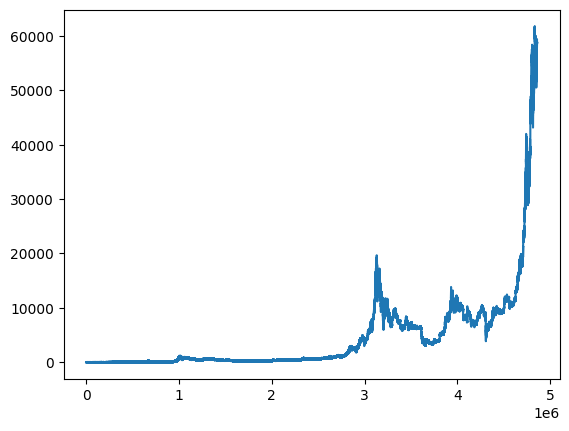

In [78]:
data['Weighted_Price'].plot()

<Axes: >

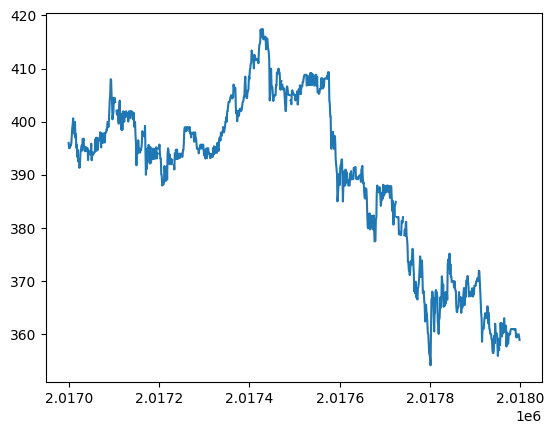

In [79]:
#plotting certain time period
data['Close'].loc['2017-01-01':'2018-01-01'].plot()

<Axes: >

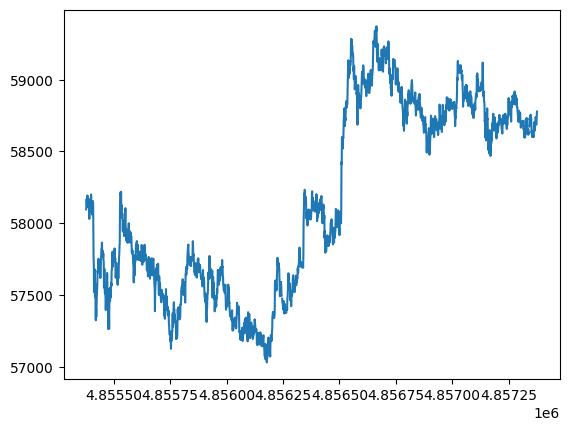

In [80]:
#plotting latest 2000 data points
data['Close'].iloc[-2000:].plot()

<Axes: >

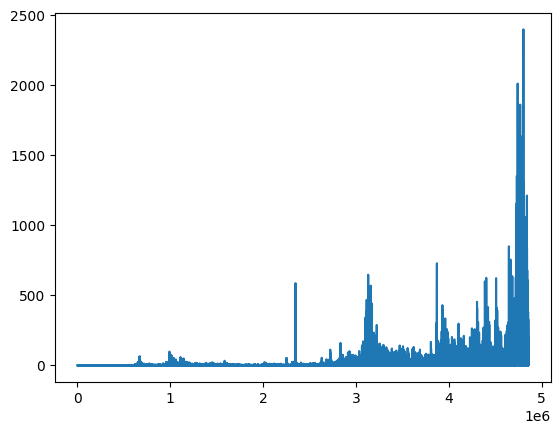

In [81]:
def difference_high_low(data):
    '''
    This function takes a dataframe as input and returns the difference between the high and low values.

    Parameters:
    data: A pandas dataframe

    Returns:
    A pandas series containing the difference between the high and low values.
    '''

    return data['High'] - data['Low']

difference_high_low(data).plot()

# Data Preprocessing

In [82]:
data['Volume_(BTC)'].fillna(method='bfill', inplace=True)
data['Volume_(Currency)'].fillna(method='bfill', inplace=True)
data['Weighted_Price'].fillna(method='bfill', inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

In [86]:
#25th june 2019 in timestamp to split
data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')

split_date = '2021-01-01'

In [91]:
#Time series data preparation
def prepare_data(data, split_date):
    '''
    This function takes a dataframe and a window size as input 
    and returns the input and target tensors.

    Parameters:
    data: A pandas dataframe
    window_size: An integer representing the window size

    Returns:
    A tuple containing the input and target tensors.
    '''

    data_train = data.loc[data['Timestamp'] <= split_date]
    data_test = data.loc[data['Timestamp'] > split_date]
    X_train = data_train['Timestamp'].values
    y_train = data_train['Weighted_Price'].values
    X_test = data_test['Timestamp'].values
    y_test = data_test['Weighted_Price'].values

    # Reshape the data
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    


    return X_train, y_train, X_test, y_test
X_train, y_train, X_test, y_test = prepare_data(data, split_date)

# Data Visualization

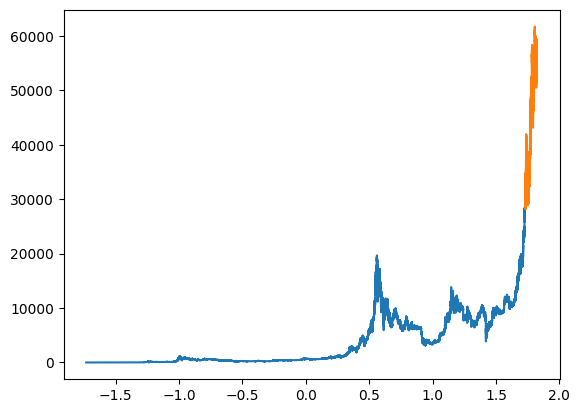

In [92]:
plt.plot(X_train, y_train, label='Train data')
plt.plot(X_test, y_test, label='Test data')

## Model Definition

In [106]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=10, activation='sigmoid', input_shape=(None, 1)),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=30, activation='relu'),
    tf.keras.layers.Dense(units=30, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=5, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10)                480       
                                                                 
 dense_54 (Dense)            (None, 5)                 55        
                                                                 
 dense_55 (Dense)            (None, 10)                60        
                                                                 
 dense_56 (Dense)            (None, 30)                330       
                                                                 
 dense_57 (Dense)            (None, 30)                930       
                                                                 
 dense_58 (Dense)            (None, 10)                310       
                                                                 
 dense_59 (Dense)            (None, 5)                

# Model Training

In [107]:
#Model Training
model.fit(X_train, y_train, batch_size=1024, epochs=100)

Epoch 1/100
4619/4619 [==============================] - 8s 2ms/step - loss: 5888576.0000
Epoch 2/100
4619/4619 [==============================] - 7s 1ms/step - loss: 1916747.3750
Epoch 3/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1874435.2500
Epoch 4/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1865883.8750
Epoch 5/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1859978.7500
Epoch 6/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1856298.0000
Epoch 7/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1853366.5000
Epoch 8/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1850519.1250
Epoch 9/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1847159.6250
Epoch 10/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1844838.1250
Epoch 11/100
4619/4619 [==============================] - 6s 1ms/step - loss: 1677036.6250
Epoch 12

In [105]:
model.save('bitcoin_price_prediction.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Evaluation

In [104]:
#Predicting all the data
predicted_price_test = model.predict(X_test)
predicted_price_train = model.predict(X_train)


147789/147789 [==============================] - 49s 334us/step


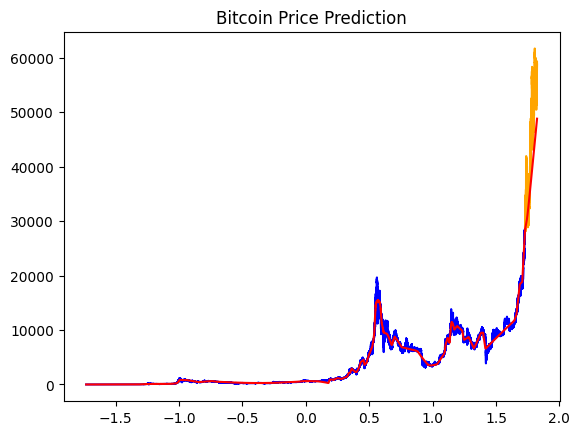

In [103]:
plt.title('Bitcoin Price Prediction')
plt.plot(X_train, y_train,color= 'blue', label='Train data')
plt.plot(X_test, y_test,color='orange', label='Test data')
plt.plot(X_test, predicted_price_test,color='red', label='Predicted data')
plt.plot(X_train, predicted_price_train,color='red', label='Predicted data')